In this notebook a PINN is trained to learn the solution for a laminar flow around a cylinder

In [ ]:
# import required libraries
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp

In [ ]:
data = sp.loadmat('FluentSol.mat')

# load experimental
x_data = data['x'].reshape((-1, 1))
y_data = data['y'].reshape((-1, 1))
p_data = data['p'].reshape((-1, 1))
u_data = data['vx'].reshape((-1, 1))
v_data = data['vy'].reshape((-1, 1))

# convert numpy arrays to tensors
x_data = tf.constant(x_data, dtype=tf.float32)
y_data = tf.constant(y_data, dtype=tf.float32)
p_data = tf.constant(p_data, dtype=tf.float32)
u_data = tf.constant(u_data, dtype=tf.float32)
v_data = tf.constant(v_data, dtype=tf.float32)

(0.0, 0.41)

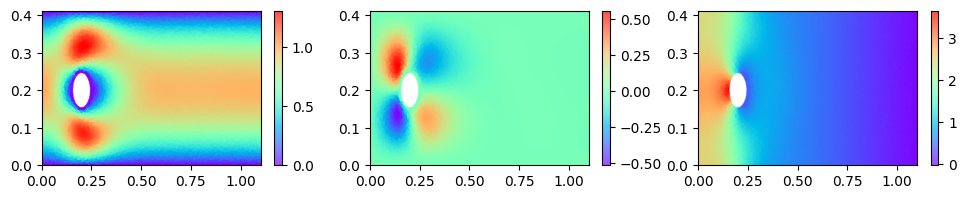

In [ ]:
# plot experimental data
fig = plt.figure(figsize=(12, 2))

ax = fig.add_subplot(131)
plot = ax.scatter(x_data, y_data, c=u_data, cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax)
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 0.41)

ax = fig.add_subplot(132)
plot = ax.scatter(x_data, y_data, c=v_data, cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax)
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 0.41)

ax = fig.add_subplot(133)
plot = ax.scatter(x_data, y_data, c=p_data, cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax)
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 0.41)

## Boundaries

Our first step is to define the boundary of the conceptual model. The model can be broken up into five different boundaries:

- Upper Wall
- Lower Wall
- Cylinder
- Inlet
- Outlet



In [ ]:
np.random.seed(1)

# set upper and lower bounds for x and y
x_min, x_max = 0.0, 1.1
y_min, y_max = 0.0, 0.41

upper_wall = [x_min, y_max] + [x_max - x_min, 0.0] * np.random.uniform(size=400).reshape((-1, 1))
lower_wall = [x_min, y_min] + [x_max - x_min, 0.0] * np.random.uniform(size=400).reshape((-1, 1))

# parameters for cylinder
r = 0.05 # radius
xc = 0.2 # center x-cord
yc = 0.2 # center y-cord

theta = [0.0] + [2 * np.pi] * np.random.uniform(size=200).reshape((-1, 1))
x_cylinder = (r * np.cos(theta)) + xc
y_cylinder = (r * np.sin(theta)) + yc
cylinder = np.concatenate((x_cylinder, y_cylinder), 1)

# assemble wall
wall = np.concatenate((cylinder, upper_wall, lower_wall), 0)
wall = tf.constant(wall, dtype=tf.float32)
wall.shape

TensorShape([1000, 2])

The inlet is where the fluid enters the model. The velocity of the fluid at the inlet is given by:

$$
\begin{align}u(0, y) &= \frac{4 U_\text{max} y(h - y)}{h^2} \\
v(0, y) &= 0
\end{align}
$$

Where $U_\text{max}$ is the maximum velocity at the inlet and $h$ is the distance between the upper and lower wall. This also describes the Neumann boundary conditions of the model at the inlet.

In [ ]:
u_max = 1.0
inlet = [x_min, y_min] + [0.0, y_max - y_min] * np.random.uniform(size=200).reshape((-1, 1))
y_inlet = inlet[:, 1:2]
u_inlet = 4 * u_max * y_inlet * (y_max - y_min - y_inlet) / ((y_max - y_min)**2) # velocity at inlet in x-direction = u(0, y)
v_inlet = 0 * y_inlet # velocity at the inlet in y-direction = 0

# assemble inlet
inlet = np.concatenate((inlet, u_inlet, v_inlet), 1)
inlet = tf.constant(inlet, dtype=tf.float32)
inlet.shape

TensorShape([200, 4])

For the outlet, we define the dirichlet boundary condition by letting the pressure equal zero at the outlet.

In [ ]:
outlet = [x_max, y_min] + [0.0, y_max - y_min] * np.random.uniform(size=200).reshape((-1, 1))
outlet = tf.constant(outlet, dtype=tf.float32)
outlet.shape

TensorShape([200, 2])

## Collocation Points

The collocation points fill the remaining domain and are used to evaluate the governing equation. The density of the collocation points is increased around the cylinder in order to better capture the dynamics.

In [ ]:
xy_collocation = [x_min, y_min] + [x_max - x_min, y_max - y_min] * np.random.uniform(size=80000).reshape((-1, 2))
xy_collocation_refine = [0.1, 0.1] + [0.2, 0.2] * np.random.uniform(size=20000).reshape((-1, 2)) # additional points around cylinder
xy_collocation = np.concatenate((xy_collocation, xy_collocation_refine, wall, inlet[:, 0:2], outlet), 0)

# remove points inside the cylinder
dst = np.array([((xy[0] - xc) ** 2 + (xy[1] - yc) ** 2) ** 0.5 for xy in xy_collocation])
xy_collocation = xy_collocation[dst > r, :]

xy_collocation = tf.constant(xy_collocation, dtype=tf.float32)
xy_collocation.shape

TensorShape([48710, 2])

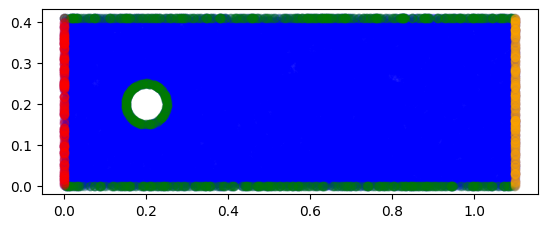

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(xy_collocation[:, 0], xy_collocation[:, 1], marker='o', alpha=0.1 ,color='blue')
plt.scatter(wall[:, 0], wall[:, 1], marker='o', alpha=0.2 , color='green')
plt.scatter(outlet[:, 0], outlet[:, 1], marker='o', alpha=0.2, color='orange')
plt.scatter(inlet[:, 0], inlet[:, 1], marker='o', alpha=0.2, color='red')
plt.show()

# PINN for Incompressible Fluid Flow

The governing equations of an incompressible flow:

$$\vec{\nabla} \cdot \vec{v} = 0$$

$$\frac{∂\vec{v}}{∂t} + (\vec{v} \cdot \vec{\nabla}) \vec{v} = -\frac{1}{\rho}\left(\vec{\nabla}p + \mu \vec{\nabla}^2\vec{v}\right) + \vec{g}$$

where $\vec{v}$ is the velocity of the fluid flow, $p$ is the pressure, $\rho$ is the density, $\mu$ is the viscosity and $\vec{g}$ is the acceleration of the flow due to gravity.

## Loss Function

$$L = \sum_{i=1}^{N_g}{||r_g(x_i, t_i)||^2}$$


# Optimization

In tensorflow the Adam optimizer is commonly used to train neural networks. A caveat to using the Adam optimizer is that it typically converges towards a local minimum. In this case the lbfgs algorthm is used to optimize the loss function.

Tensorflow does not have an in-built optimizer based on the lbfgs algorithm. As a workaround the lbfgs_minimise() from the tensorflow_probability library is used instead. Here the loss function is defined such that it takes in the model parameters as an input. Then the lbfgs_minimise() function finds the optimal values for the weights and biases.

In [ ]:
class PINN_laminar_flow:

    def __init__(self, collocation, inlet, outlet, wall, layers):

        # parameters
        self.rho = 1.0
        self.mu = 0.02

        # collocation points
        self.x_collo = collocation[:, 0:1]
        self.y_collo = collocation[:, 1:2]

        # inlet
        self.x_inlet = inlet[:, 0:1]
        self.y_inlet = inlet[:, 1:2]
        self.u_inlet = inlet[:, 2:3]
        self.v_inlet = inlet[:, 3:4]

        # outlet
        self.x_outlet = outlet[:, 0:1]
        self.y_outlet = outlet[:, 1:2]

        # upper and lower wall
        self.x_wall = wall[:, 0:1]
        self.y_wall = wall[:, 1:2]

        # neural network
        self.neural_net = self.initialize_neural_net(layers)
        self.iter = tf.Variable(0)
        self.history = []

        self.shapes = tf.shape_n(self.neural_net.trainable_variables)
        self.n_tensors = len(self.shapes) # number of weight matrices

        count = 0
        self.idx = [] # stitch indices
        self.part = [] # partition indices

        for i, shape in enumerate(self.shapes):
            n = np.prod(shape) # number of elements in weight matrix
            self.idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            self.part.extend([i]*n)
            count += n

        self.part = tf.constant(self.part)

    def initialize_neural_net(self, layers):
        neural_net = tf.keras.Sequential()

        # input layer
        neural_net.add(tf.keras.layers.Input(shape=(2, )))

        # hidden layers
        for neurons in layers:
            neural_net.add(tf.keras.layers.Dense(neurons, activation='tanh'))

        # output layer
        neural_net.add(tf.keras.layers.Dense(3))

        return neural_net

    def predict(self, x, y):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch((x, y))
            inputs = tf.concat((x, y), axis=1)
            pred = self.neural_net(inputs)
            # stream function
            psi = pred[:, 0:1]

        # velocity
        u = tape.gradient(psi, y)
        v = -tape.gradient(psi, x)

        # pressure
        p = pred[:, 1:2]

        return u, v, p

    @tf.function
    def assign_new_model_parameters(self, params_1d):
        params = tf.dynamic_partition(params_1d, self.part, self.n_tensors)
        for i, (shape, param) in enumerate(zip(self.shapes, params)):
            self.neural_net.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def value_and_gradients_loss(self, params_1d):
        with tf.GradientTape() as tape:
            self.assign_new_model_parameters(params_1d)
            loss_value = self.loss()

        grads = tape.gradient(loss_value, self.neural_net.trainable_variables)
        grads = tf.dynamic_stitch(self.idx, grads)

        self.iter.assign_add(1)
        tf.print("Iter:", self.iter, "loss:", loss_value)

        tf.py_function(self.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    def train(self, max_iterations):
        init_params = tf.dynamic_stitch(self.idx, self.neural_net.trainable_variables)

        # use a gpu to reduce training time
        with tf.device('/device:GPU:0'):

            results = tfp.optimizer.lbfgs_minimize(
                value_and_gradients_function=self.value_and_gradients_loss,
                initial_position=init_params,
                max_iterations=max_iterations,
                max_line_search_iterations=50,
                tolerance=0.,
                x_tolerance = 0.,
                f_absolute_tolerance = 0.
            )

        self.assign_new_model_parameters(results.position)

    def loss(self):

        physics_loss = self.physics_loss()
        boundary_loss = self.boundary_loss()

        return physics_loss + 10 * boundary_loss


    def physics_loss(self):

        # calculate derivatives
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch((self.x_collo, self.y_collo))

            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch((self.x_collo, self.y_collo))
                u, v, p = self.predict(self.x_collo, self.y_collo,)

            # first derivatives
            u_x = tape2.gradient(u, self.x_collo)
            u_y = tape2.gradient(u, self.y_collo)
            v_x = tape2.gradient(v, self.x_collo)
            v_y = tape2.gradient(v, self.y_collo)
            p_x = tape2.gradient(p, self.x_collo)
            p_y = tape2.gradient(p, self.y_collo)

        # second derivatives
        u_xx = tape1.gradient(u_x, self.x_collo)
        u_yy = tape1.gradient(u_y, self.y_collo)
        v_xx = tape1.gradient(v_x, self.x_collo)
        v_yy = tape1.gradient(v_y, self.y_collo)

        # navier stokes equations
        f_u = self.rho * (u * u_x + v * u_y) + p_x - self.mu * (u_xx + u_yy)
        f_v = self.rho * (u * v_x + v * v_y) + p_y - self.mu * (v_xx + v_yy)

        loss = tf.reduce_mean(tf.square(f_u)) \
             + tf.reduce_mean(tf.square(f_v))

        return loss


    def boundary_loss(self):

        u_wall_pred, v_wall_pred, _ = self.predict(self.x_wall, self.y_wall)
        u_inlet_pred, v_inlet_pred, _ = self.predict(self.x_inlet, self.y_inlet)
        _, _, p_outlet_pred = self.predict(self.x_outlet, self.y_outlet)

        loss = tf.reduce_mean(tf.square(u_wall_pred)) \
             + tf.reduce_mean(tf.square(v_wall_pred)) \
             + tf.reduce_mean(tf.square(u_inlet_pred - self.u_inlet)) \
             + tf.reduce_mean(tf.square(v_inlet_pred - self.v_inlet)) \
             + tf.reduce_mean(tf.square(p_outlet_pred))

        return loss

In [ ]:
layers = 8*[40]
model = PINN_laminar_flow(xy_collocation, inlet, outlet, wall, layers)
model.neural_net.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 40)                120       
                                                                 
 dense_37 (Dense)            (None, 40)                1640      
                                                                 
 dense_38 (Dense)            (None, 40)                1640      
                                                                 
 dense_39 (Dense)            (None, 40)                1640      
                                                                 
 dense_40 (Dense)            (None, 40)                1640      
                                                                 
 dense_41 (Dense)            (None, 40)                1640      
                                                                 
 dense_42 (Dense)            (None, 40)               

In [ ]:
model.loss()

<tf.Tensor: shape=(), dtype=float32, numpy=3.379451>

In [ ]:
model.train(100_000)

Streaming output truncated to the last 5000 lines.
Iter: 44356 loss: 0.0173346922
Iter: 44357 loss: 0.0173429623
Iter: 44358 loss: 0.0173313748
Iter: 44359 loss: 0.0173324
Iter: 44360 loss: 0.0173290223
Iter: 44361 loss: 0.0173269119
Iter: 44362 loss: 0.0173216127
Iter: 44363 loss: 0.0173852108
Iter: 44364 loss: 0.0173211657
Iter: 44365 loss: 0.0173203442
Iter: 44366 loss: 0.0173187
Iter: 44367 loss: 0.0173165314
Iter: 44368 loss: 0.017321622
Iter: 44369 loss: 0.0173158534
Iter: 44370 loss: 0.0173132755
Iter: 44371 loss: 0.0173158795
Iter: 44372 loss: 0.0173119642
Iter: 44373 loss: 0.0173091982
Iter: 44374 loss: 0.017338274
Iter: 44375 loss: 0.0173090119
Iter: 44376 loss: 0.0173078422
Iter: 44377 loss: 0.0173034
Iter: 44378 loss: 0.0173057038
Iter: 44379 loss: 0.0172996763
Iter: 44380 loss: 0.0172931477
Iter: 44381 loss: 0.0173878632
Iter: 44382 loss: 0.0172931701
Iter: 44383 loss: 0.0172897168
Iter: 44384 loss: 0.017335292
Iter: 44385 loss: 0.0172897745
Iter: 44386 loss: 0.0172878914


In [ ]:
#model.neural_net = tf.keras.models.load_model('content/drive/My Drive/Colab Notebooks/steady_laminar_flow')
#loss = np.load('content/drive/My Drive/Colab Notebooks/steady_laminar_flow_loss.npy').tolist()
#model.neural_net.summary()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

model.neural_net.save('steady_laminar_flow_lbfgs_49355')
np.save('steady_laminar_flow_loss_lbfgs_49355.npy', np.array(model.history))

(0.0, 0.41)

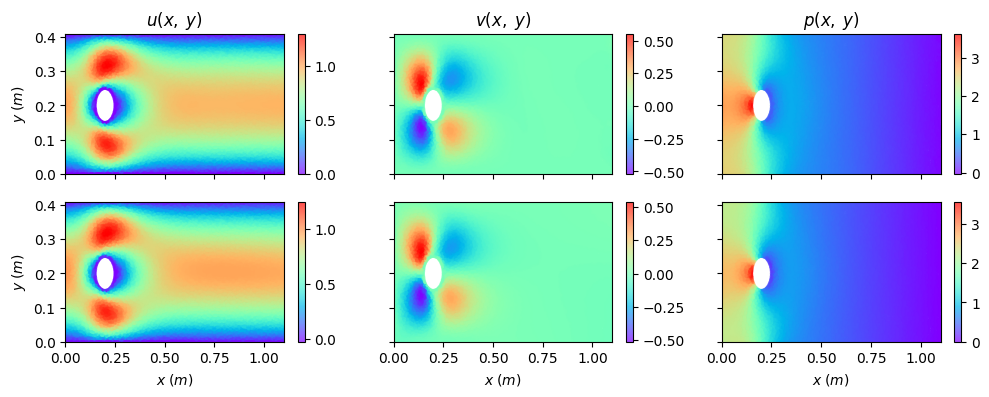

In [ ]:
pred = model.predict(x_data, y_data)

fig, ax = plt.subplots(2, 3, figsize=(12, 4), sharex=True, sharey=True)

#ax = fig.add_subplot(231)
plot = ax[0, 0].scatter(x, y, c=u_data, cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax[0, 0])
ax[0, 0].set_title("$u(x,\; y)$")
ax[0, 0].set_ylabel("$y \; (m)$")
ax[0, 0].set_xlim(0, 1.1)
ax[0, 0].set_ylim(0, 0.41)
ax[0, 0].annotate("a", xy=(-0.25, 0))

#ax = fig.add_subplot(232)
plot = ax[0, 1].scatter(x, y, c=v_data, cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax[0, 1])
ax[0, 1].set_title("$v(x,\; y)$")
ax[0, 1].set_xlim(0, 1.1)
ax[0, 1].set_ylim(0, 0.41)

#ax = fig.add_subplot(233)
plot = ax[0, 2].scatter(x, y, c=p_data, cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax[0, 2])
ax[0, 2].set_title("$p(x,\; y)$")
ax[0, 2].set_xlim(0, 1.1)
ax[0, 2].set_ylim(0, 0.41)

#ax = fig.add_subplot(234)
plot = ax[1, 0].scatter(x, y, c=pred[0], cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax[1, 0])
ax[1, 0].set_xlabel("$x \; (m)$")
ax[1, 0].set_ylabel("$y \; (m)$")
ax[1, 0].set_xlim(0, 1.1)
ax[1, 0].set_ylim(0, 0.41)

# ax = fig.add_subplot(235)
plot = ax[1, 1].scatter(x, y, c=pred[1], cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax[1, 1])
ax[1, 1].set_xlabel("$x \; (m)$")
ax[1, 1].set_xlim(0, 1.1)
ax[1, 1].set_ylim(0, 0.41)

# ax = fig.add_subplot(236)
plot = ax[1, 2].scatter(x, y, c=pred[2], cmap='rainbow', alpha=0.7, s=2)
fig.colorbar(plot, ax=ax[1, 2])
ax[1, 2].set_xlabel("$x \; (m)$")
ax[1, 2].set_xlim(0, 1.1)
ax[1, 2].set_ylim(0, 0.41)



In [ ]:
fig.savefig("steady_laminar_flow.png")

In [ ]:
def relative_error(x_pred, x_true):
    return tf.math.sqrt(tf.reduce_sum(tf.square(x_pred - x_true))) / tf.math.sqrt(tf.reduce_sum(tf.square(x_true)))

print(relative_error(pred[0], u_data).numpy())
print(relative_error(pred[1], v_data).numpy())
print(relative_error(pred[2], p_data).numpy())

0.038916066
0.08556181
0.07912774


In [ ]:
model.physics_loss()

<tf.Tensor: shape=(), dtype=float32, numpy=8.712498e-06>

In [ ]:
model.boundary_loss()

<tf.Tensor: shape=(), dtype=float32, numpy=1.6387577e-05>

To include time dependence we have to

